## Part I: Read Data and Pre-Process

Import phcovid package and use <b>get_cases</b> to return latest data from source

In [1]:
import numpy as np
import pandas as pd
import os, sys

package_dir = os.path.normpath(os.getcwd() + os.sep + os.pardir) 
sys.path.append(package_dir)

In [5]:
import phcovid
df = phcovid.get_cases()
df.head()

,attributes.FID,case_no,confirmation_date,age,epi_link,facility,sex,latitude,longitude,nationality,...,attributes.sequ,status,symptoms,travel_history,geometry.x,geometry.y,contacts,num_contacts,case_no_num,contacts_num
0,1,PH501,NaT,60,,St. Luke's Medical Center - Global City,Male,14.555128,121.048256,for_validation,...,501,,,for_validation,1.347503e+07,1.637983e+06,[],0,501,[]
1,2,PH502,NaT,56,,Cardinal Santos Medical Center,Female,14.597596,121.045994,Filipino,...,502,,,for_validation,1.347478e+07,1.642868e+06,[],0,502,[]
2,3,PH503,NaT,74,,Cardinal Santos Medical Center,Male,14.597596,121.045994,Filipino,...,503,,,for_validation,1.347478e+07,1.642868e+06,[],0,503,[]
3,4,PH504,NaT,61,,Cardinal Santos Medical Center,Male,14.597596,121.045994,Filipino,...,504,,,for_validation,1.347478e+07,1.642868e+06,[],0,504,[]
4,5,PH505,NaT,32,,Cardinal Santos Medical Center,Male,14.597596,121.045994,Filipino,...,505,,,for_validation,1.347478e+07,1.642868e+06,[],0,505,[]


## Part II: Connected Components Analysis

<b>Use get_case_network</b> module to identify all networks of conected cases

In [7]:
case_network = phcovid.get_case_network(df)
case_network.head()

,network_no,network_cases,network_num_cases
0,0,"[1, 2]",2
1,1,[3],1
2,2,[4],1
3,3,"[5, 6, 38]",3
4,4,[7],1


<b>a.) Multiple cases, especially the initial ones can be traced to networks of 3+ people where transmission occured.</b> The largest network is comprised of 8 people: [12, 34, 35, 42, 43, 84, 86, 204].
<br>
<br>
<i>List of all networks with 3+ Cases shown below:</i>

In [9]:
case_network[case_network['network_num_cases']>=3].head()

,network_no,network_cases,network_num_cases
3,3,"[5, 6, 38]",3
6,6,"[9, 27, 28, 29, 30, 31]",6
9,9,"[12, 34, 35, 42, 43, 84, 86, 204]",8
16,16,"[21, 65, 66, 67]",4
28,28,"[41, 44, 87, 112]",4


<b>b.) Largest Network (Network 9) has loose connections and is split among multiple hospitals in NCR across 10 days. </b> <br>
<i>Network details are shown below:</i>

In [23]:
cases_largest_network = list(case_network.loc[case_network['network_no']==9,'network_cases'])[0]
df[df['case_no_num'].isin(cases_largest_network)]

,attributes.FID,case_no,confirmation_date,age,epi_link,facility,sex,latitude,longitude,nationality,...,attributes.sequ,status,symptoms,travel_history,geometry.x,geometry.y,contacts,num_contacts,case_no_num,contacts_num
314,315,PH12,2020-03-09,56,,Makati Medical Center,Male,14.559177,121.014546,Filipino,...,12,,,"Contact of PH42, PH43",1.347128e+07,1.638449e+06,"[PH42, PH43]",2,12,"[42, 43]"
336,337,PH34,2020-03-11,72,,Lung Center of the Philippines,Male,14.647821,121.045763,Filipino,...,34,,,Husband of PH35,1.347475e+07,1.648646e+06,[PH35],1,34,[35]
337,338,PH35,2020-03-11,67,,Manila Doctors Hospital,Female,14.582028,120.982657,Filipino,...,35,,,Wife of PH34,1.346773e+07,1.641077e+06,[PH34],1,35,[34]
344,345,PH42,2020-03-11,51,,Lung Center of the Philippines,Male,14.647821,121.045763,Filipino,...,42,,,Japan,1.347475e+07,1.648646e+06,[],0,42,[]
345,346,PH43,2020-03-11,47,,Lung Center of the Philippines,Male,14.647821,121.045763,Filipino,...,43,,,Wife is Sister of PH12; Close Contact of PH35,1.347475e+07,1.648646e+06,"[PH12, PH35]",2,43,"[12, 35]"
386,387,PH84,2020-03-13,38,,St. Luke's Medical Center - Global City,Male,14.555128,121.048256,Filipino,...,84,,,Contact of PH43,1.347503e+07,1.637983e+06,[PH43],1,84,[43]
388,389,PH86,2020-03-13,48,,Research Institute for Tropical Medicine,Male,14.409523,121.037122,Filipino,...,86,,,Contact of PH43,1.347379e+07,1.621242e+06,[PH43],1,86,[43]
506,507,PH204,2020-03-18,32,,Manila Doctors Hospital,Female,14.582028,120.982657,Filipino,...,204,,,Contact of PH35,1.346773e+07,1.641077e+06,[PH35],1,204,[35]


<b>c.) Identify what % of cases come from networks of 2+ cases</b>

In [25]:
network_cnt = len(case_network)
cases_cnt = len(df)
print("Number of unique networks: ", network_cnt)
print("Number of unique cases: ", cases_cnt)
print(f"Percentage of Transmissions in networks of 2+: {round(100*(1-network_cnt/cases_cnt),2)}%")

Number of unique networks:  770
Number of unique cases:  803
Percentage of Transmissions in networks of 2+: 4.11%


## Part III: Monitoring

Much has already been said on the importance of <b>flattening the curve.</b> It can be shown that flattening the curve for the country begins with flattening the curve for each of the networks. That is, we should stop the networks of connected cases from growing. This can be accomplished with appropriate personal hygeine measures and social distancing whenever possible. 

<b>Use get_case_plot to show the growth of confirmed cases in PH</b>
<br>
<br><i>As of today, the growth of total PH cases is still rising</i>

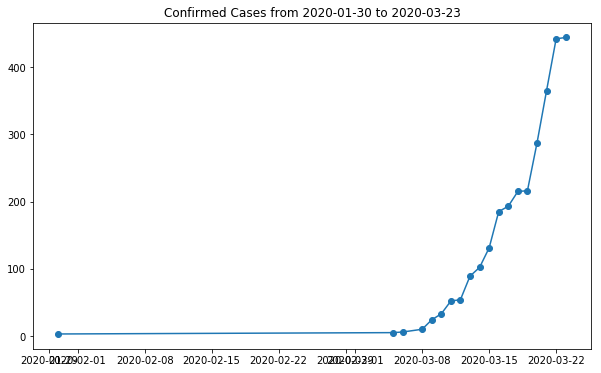

In [26]:
from phcovid import get_case_plot
get_case_plot(df)

Use start_date functionality. <i>Plot only cases in March.</i>

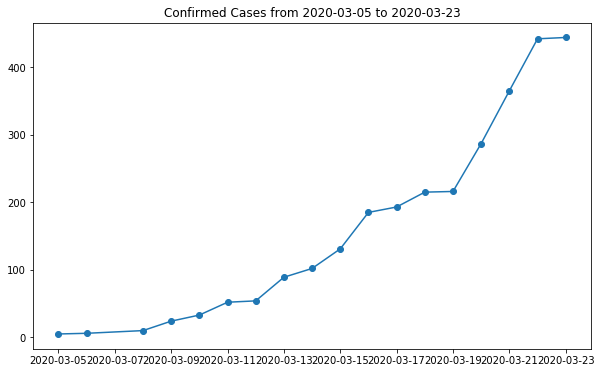

In [27]:
get_case_plot(df, start_date="03-02-20")

### Monitoring Large Networks

<b>Growth of confirmed cases within networks</b>
<br><i>Contact tracing and quarantine recommendations to large networks are important.</i>

<u>Case growth within Network 9:</u> <i>Case growth in Network 9 is seen to be flattening, with the latest case recorded 3/18/20.
This could indicate that the quarantine and preventive measures imposed on this network has been effective. Although we need to wait for more details and contact tracing of new cases to confirm. </i>

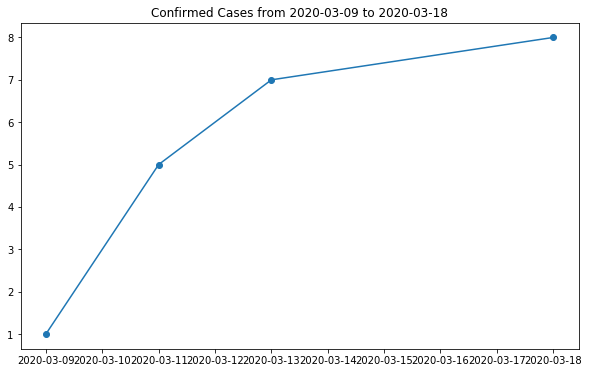

In [29]:
get_case_plot(df[df['case_no_num'].isin(cases_largest_network)])